# Models > Neural Networks (MLP)

<div class="alert alert-info">Estimate and tune a Multi-Layer Perceptron model for binary classification</div>

In [1]:
import os
import numpy as np
import pandas as pd
import pyrsm as rsm
import matplotlib as mpl
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# increase plot resolution
mpl.rcParams["figure.dpi"] = 100

In [2]:
# needs pyrsm version 1.0.4 or higher
# update using pip install --user pyrsm --upgrade
rsm.__version__

'1.5.0'

In [3]:
## setup pyrsm for autoreload
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

### Example

As an example we will use a dataset that describes the survival status of individual passengers on the Titanic. The principal source for data about Titanic passengers is the Encyclopedia Titanic. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay. Suppose we want to investigate which factors are most strongly associated with the chance of surviving the sinking of the Titanic. Lets focus on four variables in the database:

- survived = a factor with levels `Yes` and `No`
- pclass = Passenger Class (1st, 2nd, 3rd). This is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower
- sex = Sex (female, male)
- age = Age in years

Select `survived` as the response variable and `Yes` in **Choose level**. Select `pclass`, `sex` and `age` as the explanatory variables. In contrast to Logistic Regression, a Machine Learning model like a Random Forest does not provide coefficients or odds-ratios that we can interpret. Instead, the model provides predictions that we need to evaluate for accuracy. We will also use different plots to better understand what the Random Forest model is telling us about the connection between the explanatory variables (i.e., features) and the response variable (i.e., target).


In [4]:
titanic, titanic_description = rsm.load_data(pkg="data", name="titanic")
titanic

,pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked
0,1st,Yes,female,29.0000,0,0,211.337494,"Allen, Miss. Elisabeth Walton",B5,Southampton
1,1st,Yes,male,0.9167,1,2,151.550003,"Allison, Master. Hudson Trevor",C22 C26,Southampton
2,1st,No,female,2.0000,1,2,151.550003,"Allison, Miss. Helen Loraine",C22 C26,Southampton
3,1st,No,male,30.0000,1,2,151.550003,"Allison, Mr. Hudson Joshua Crei",C22 C26,Southampton
4,1st,No,female,25.0000,1,2,151.550003,"Allison, Mrs. Hudson J C (Bessi",C22 C26,Southampton
...,...,...,...,...,...,...,...,...,...,...
1038,3rd,No,male,45.5000,0,0,7.225000,"Youseff, Mr. Gerious",,Cherbourg
1039,3rd,No,female,14.5000,1,0,14.454200,"Zabour, Miss. Hileni",,Cherbourg
1040,3rd,No,male,26.5000,0,0,7.225000,"Zakarian, Mr. Mapriededer",,Cherbourg
1041,3rd,No,male,27.0000,0,0,7.225000,"Zakarian, Mr. Ortin",,Cherbourg


In [5]:
rsm.md(titanic_description)

## Titanic

This dataset describes the survival status of individual passengers on the Titanic. The titanic data frame does not contain information from the crew, but it does contain actual ages of (some of) the passengers. The principal source for data about Titanic passengers is the Encyclopedia Titanica. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay.

## Variables

* survival - Survival (Yes, No)
* pclass - Passenger Class (1st, 2nd, 3rd)
* sex - Sex (female, male)
* age - Age in years
* sibsp - Number of Siblings/Spouses Aboard
* parch - Number of Parents/Children Aboard
* fare - Passenger Fare
* name - Name
* cabin - Cabin
* embarked - Port of Embarkation (Cherbourg, Queenstown, Southampton)

##  Notes

`pclass` is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1). If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch) some relations were ignored.  The following are the definitions used for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins, nephews/nieces, aunts/uncles, and in-laws. Some children travelled only with a nanny, therefore parch=0 for them.  As well, some travelled with very close friends or neighbors in a village, however, the definitions do not support such relations.

Note: Missing values and the `ticket` variable were removed from the data

## Related reading

<a href="http://phys.org/news/2012-07-shipwrecks-men-survive.html" target="_blank">In shipwrecks, men more likely to survive</a>

In [6]:
titanic.head()

,pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked
0,1st,Yes,female,29.0000,0,0,211.337494,"Allen, Miss. Elisabeth Walton",B5,Southampton
1,1st,Yes,male,0.9167,1,2,151.550003,"Allison, Master. Hudson Trevor",C22 C26,Southampton
2,1st,No,female,2.0000,1,2,151.550003,"Allison, Miss. Helen Loraine",C22 C26,Southampton
3,1st,No,male,30.0000,1,2,151.550003,"Allison, Mr. Hudson Joshua Crei",C22 C26,Southampton
4,1st,No,female,25.0000,1,2,151.550003,"Allison, Mrs. Hudson J C (Bessi",C22 C26,Southampton


In [7]:
titanic.columns

Index(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'name',
       'cabin', 'embarked'],
      dtype='object')

In [8]:
evar = list(titanic.columns[[0, 2, 3, 4, 5, 6]])
evar

['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare']

In [9]:
clf_nn = rsm.model.mlp(
    {"titanic": titanic},
    hidden_layer_sizes=(1,),
    alpha=0.001,
    rvar="survived",
    lev="Yes",
    evar=evar,
)
clf_nn.summary()

Multi-layer Perceptron (NN)
Data                 : titanic
Response variable    : survived
Level                : Yes
Explanatory variables: pclass, sex, age, sibsp, parch, fare
Model type           : classification
Nr. of features      : (6, 7)
Nr. of weights       : 10
Nr. of observations  : 1,043
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.842

Raw data             :
pclass    sex     age  sibsp  parch       fare
   1st female 29.0000      0      0 211.337494
   1st   male  0.9167      1      2 151.550003
   1st female  2.0000      1      2 151.550003
   1st   male 30.0000      1      2 151.550003
   1st female 25.0000      1      2 151.550003

Estimation data      :
      age     sibsp     parch     fare  pclass_2nd  pclass_3rd  sex_male
-0.056632 -0.552587 -0.502064 3.13554

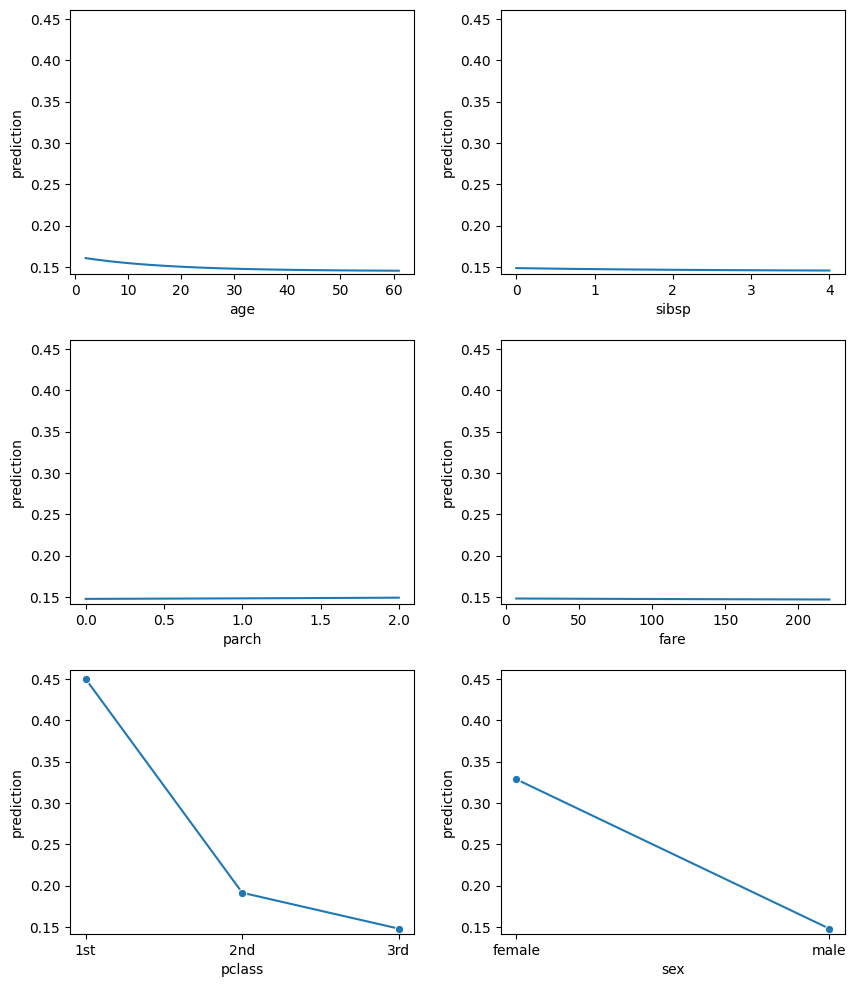

In [10]:
clf_nn.plot("pred")

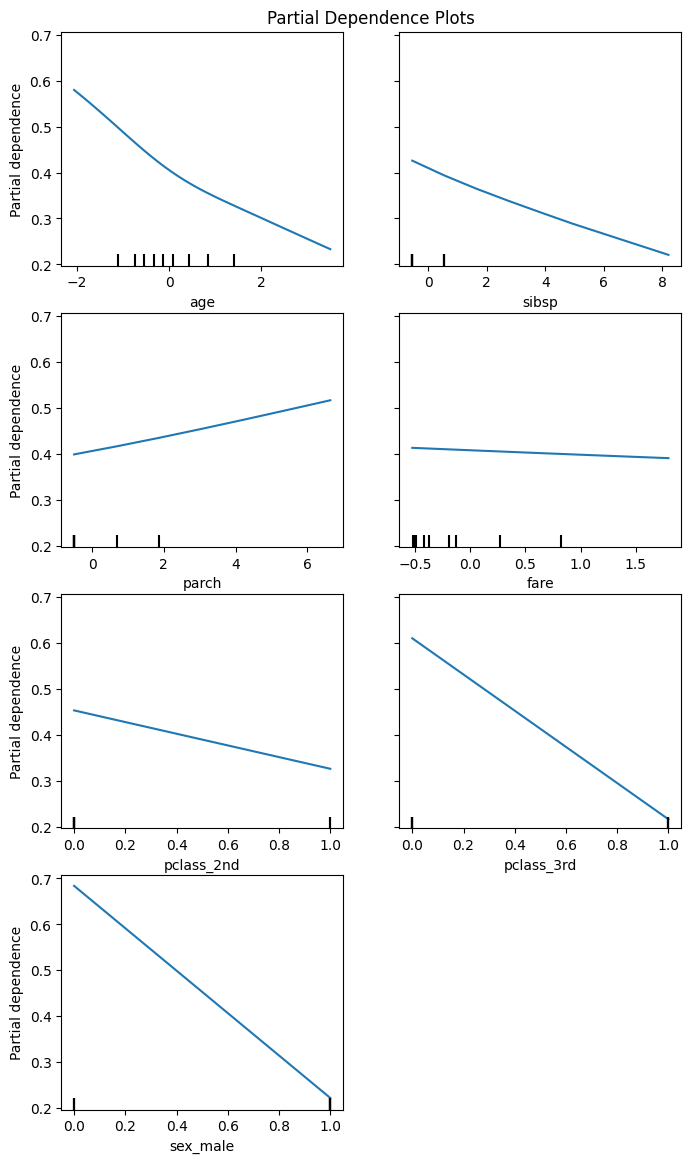

In [11]:
clf_nn.plot(plots="pdp")

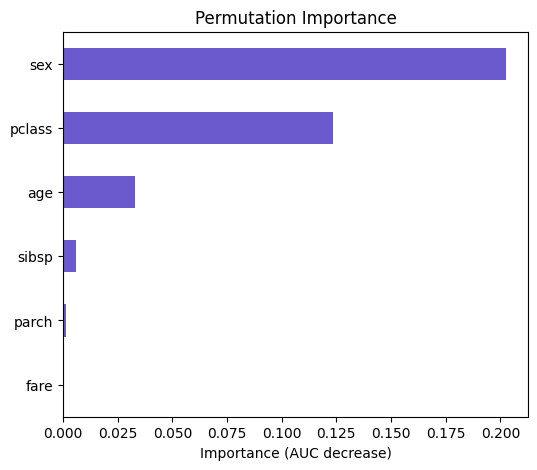

In [12]:
clf_nn.plot("vimp")

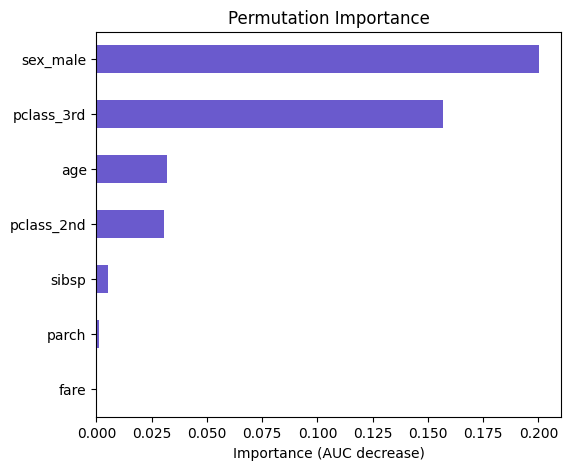

In [13]:
clf_nn.plot("vimp_sklearn")

In [14]:
clf_nn.predict(titanic)

,pclass,sex,age,sibsp,parch,fare,prediction
0,1st,female,29.0000,0,0,211.337494,0.961581
1,1st,male,0.9167,1,2,151.550003,0.858781
2,1st,female,2.0000,1,2,151.550003,0.968730
3,1st,male,30.0000,1,2,151.550003,0.415671
4,1st,female,25.0000,1,2,151.550003,0.964489
...,...,...,...,...,...,...,...
1038,3rd,male,45.5000,0,0,7.225000,0.146276
1039,3rd,female,14.5000,1,0,14.454200,0.490400
1040,3rd,male,26.5000,0,0,7.225000,0.149201
1041,3rd,male,27.0000,0,0,7.225000,0.149073


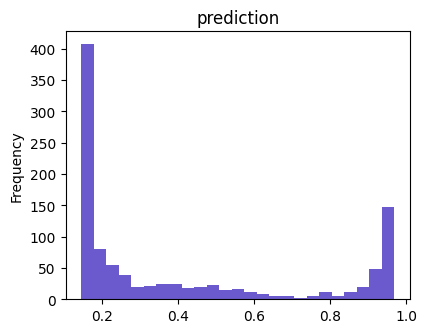

In [15]:
rsm.model.distr_plot(clf_nn.predict(titanic).prediction)

In addition to the numerical output provided in the _Summary_ tab we can also evaluate the link between `survival`, `class`, `sex`, and `age` visually (see _Plot_ tab). 


# Radiant for Python App: Multi-layer Perceptron (NN) - Classification

All the output shown above can be reproduced using the Radiant-for-Python web interface. An example of what the code required to start the web interface is shown below. See if you can reproduce the result.

> Note: The app will continue running until you press the `Stop` button in the app navigation bar or the stop button next to the notebook cell


In [16]:
# uncomment the line below if you want to use the radiant web interface
# rsm.radiant.model.mlp({"titanic": titanic}, {"titanic": titanic_description})

<p align="center">
<img src="figures/mlp-classification-summary.png">
</p>

<p align="center">
<img src="figures/mlp-classification-pred-plots.png">
</p>


## Tuning an MLP (NN) classification model

When building an MLP (Neural Network) model, there are several hyperparameters that can be tuned to improve model performance. Two key parameters we'll focus on are:

- `hidden_layer_sizes`: The number of hidden layers and the number of neurons in each hidden layer
- `alpha`: The regularization parameter (L2 penalty)

To find the optimal combination of these parameters, we'll:

1. Split our data into training (70%) and test (30%) sets
2. Use grid search with 5-fold cross validation to evaluate different parameter combinations
3. Compare model performance with default vs tuned parameters

First, let's create our train/test split:

In [17]:
titanic["training"] = rsm.model.make_train(titanic, strat_var="survived", test_size=0.3, random_state=1234)
print(titanic.head())

  pclass survived     sex      age  sibsp  parch        fare  \
0    1st      Yes  female  29.0000      0      0  211.337494   
1    1st      Yes    male   0.9167      1      2  151.550003   
2    1st       No  female   2.0000      1      2  151.550003   
3    1st       No    male  30.0000      1      2  151.550003   
4    1st       No  female  25.0000      1      2  151.550003   

                              name    cabin     embarked  training  
0    Allen, Miss. Elisabeth Walton       B5  Southampton       0.0  
1   Allison, Master. Hudson Trevor  C22 C26  Southampton       1.0  
2     Allison, Miss. Helen Loraine  C22 C26  Southampton       1.0  
3  Allison, Mr. Hudson Joshua Crei  C22 C26  Southampton       0.0  
4  Allison, Mrs. Hudson J C (Bessi  C22 C26  Southampton       1.0  


In [18]:
clf_nn = rsm.model.mlp(
    {"titanic (train)": titanic[titanic.training == 1]},
    hidden_layer_sizes=(1,),
    alpha=0.001,
    rvar="survived",
    lev="Yes",
    evar=evar,
)
clf_nn.summary()

Multi-layer Perceptron (NN)
Data                 : titanic (train)
Response variable    : survived
Level                : Yes
Explanatory variables: pclass, sex, age, sibsp, parch, fare
Model type           : classification
Nr. of features      : (6, 7)
Nr. of weights       : 10
Nr. of observations  : 730
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.835

Raw data             :
pclass    sex     age  sibsp  parch       fare
   1st   male  0.9167      1      2 151.550003
   1st female  2.0000      1      2 151.550003
   1st female 25.0000      1      2 151.550003
   1st female 53.0000      2      0  51.479199
   1st   male 47.0000      1      0 227.524994

Estimation data      :
      age    sibsp     parch     fare  pclass_2nd  pclass_3rd  sex_male
-2.042643 0.527718  1.779310 1.8

The initial model used default parameters. Let's evaluate different combinations of parameters using grid search cross validation. We'll try:

- hidden_layer_sizes: 1 to 10 neurons in a single hidden layer
- alpha: regularization parameter from 0.0 to 1.0 (in steps of 0.1)

We'll use the AUC (Area Under the ROC Curve) metric to evaluate performance:

In [19]:
hls = [(i,) for i in range(1, 11)]
param_grid = {"hidden_layer_sizes": hls, "alpha": np.arange(0.0, 1.1, 0.1)}
scoring = {"AUC": "roc_auc"}
param_grid

{'hidden_layer_sizes': [(1,),
  (2,),
  (3,),
  (4,),
  (5,),
  (6,),
  (7,),
  (8,),
  (9,),
  (10,)],
 'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}

In [20]:
cv_file = "cv-objects/clf-nn-cross-validation-object.pkl"
if os.path.exists(cv_file):
    cv = rsm.load_state(cv_file)["cv"]
else:
    stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    cv = GridSearchCV(
        clf_nn.fitted,
        param_grid,
        scoring=scoring,
        cv=stratified_k_fold,
        n_jobs=4,
        refit=list(scoring.keys())[0],
        verbose=5,
    ).fit(clf_nn.data_onehot, clf_nn.data.survived)
    if not os.path.exists("cv-objects"):
        os.mkdir("cv-objects")
    rsm.save_state({"cv": cv}, cv_file)

In [21]:
# same functionality as the cell above but less typing
cv = rsm.model.cross_validation(clf_nn, "clf-nn", param_grid, scoring)

The best parameters are: {'alpha': np.float64(0.8), 'hidden_layer_sizes': (5,)}
The best model fit score is: 0.847322285349245
The GirdSearchCV model fit estimates:
      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
84        0.016843      0.005162         0.001047        0.000088   
108       0.030804      0.003367         0.001109        0.000097   
106       0.020926      0.004203         0.001178        0.000088   
87        0.026860      0.007726         0.001060        0.000115   
97        0.022682      0.004059         0.001232        0.000077   

     param_alpha param_hidden_layer_sizes  \
84           0.8                     (5,)   
108          1.0                     (9,)   
106          1.0                     (7,)   
87           0.8                     (8,)   
97           0.9                     (8,)   

                                         params  split0_test_AUC  \
84   {'alpha': 0.8, 'hidden_layer_sizes': (5,)}         0.837597   
108  {'alpha

In [22]:
cv.best_params_

{'alpha': np.float64(0.8), 'hidden_layer_sizes': (5,)}

In [23]:
cv.best_score_

np.float64(0.847322285349245)

In [24]:
pd.DataFrame(cv.cv_results_).sort_values("rank_test_AUC").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
84,0.016843,0.005162,0.001047,0.000088,0.8,"(5,)","{'alpha': 0.8, 'hidden_layer_sizes': (5,)}",0.837597,0.846609,0.886324,0.872005,0.794078,0.847322,0.031813,1
108,0.030804,0.003367,0.001109,0.000097,1.0,"(9,)","{'alpha': 1.0, 'hidden_layer_sizes': (9,)}",0.834884,0.846415,0.881648,0.878239,0.793103,0.846858,0.032336,2
106,0.020926,0.004203,0.001178,0.000088,1.0,"(7,)","{'alpha': 1.0, 'hidden_layer_sizes': (7,)}",0.851938,0.830329,0.878921,0.872979,0.799338,0.846701,0.029214,3
87,0.026860,0.007726,0.001060,0.000115,0.8,"(8,)","{'alpha': 0.8, 'hidden_layer_sizes': (8,)}",0.840698,0.814826,0.889246,0.885447,0.801286,0.846300,0.035847,4
97,0.022682,0.004059,0.001232,0.000077,0.9,"(8,)","{'alpha': 0.9, 'hidden_layer_sizes': (8,)}",0.843798,0.827616,0.885739,0.879408,0.794078,0.846128,0.033864,5


After finding the optimal parameters, we can build a new model with these tuned parameters and compare its performance to our original model. Looking at the gains charts for both the training and test sets helps us evaluate overfitting while maintaining good predictive performance.

The cross validation results show that slightly different parameter values perform best with this particular dataset compared to the defaults. This demonstrates the value of parameter tuning, though the magnitude of improvement will vary by application.

In [25]:
clf_nncv = rsm.model.mlp(
    data={"titanic train": titanic[titanic.training == 1]},
    rvar="survived",
    lev="Yes",
    evar=evar,
    random_state=1234,
    **cv.best_params_
)
clf_nncv.summary()

Multi-layer Perceptron (NN)
Data                 : titanic train
Response variable    : survived
Level                : Yes
Explanatory variables: pclass, sex, age, sibsp, parch, fare
Model type           : classification
Nr. of features      : (6, 7)
Nr. of weights       : 46
Nr. of observations  : 730
Hidden_layer_sizes   : (5,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.8
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.881

Raw data             :
pclass    sex     age  sibsp  parch       fare
   1st   male  0.9167      1      2 151.550003
   1st female  2.0000      1      2 151.550003
   1st female 25.0000      1      2 151.550003
   1st female 53.0000      2      0  51.479199
   1st   male 47.0000      1      0 227.524994

Estimation data      :
      age    sibsp     parch     fare  pclass_2nd  pclass_3rd  sex_male
-2.042643 0.527718  1.779310 1.89334

In [26]:
titanic["pred_nn"] = clf_nn.predict(titanic)["prediction"]
titanic["pred_nncv"] = clf_nncv.predict(titanic)["prediction"]
titanic

,pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked,training,pred_nn,pred_nncv
0,1st,Yes,female,29.0000,0,0,211.337494,"Allen, Miss. Elisabeth Walton",B5,Southampton,0.0,0.968222,0.957504
1,1st,Yes,male,0.9167,1,2,151.550003,"Allison, Master. Hudson Trevor",C22 C26,Southampton,1.0,0.734623,0.806857
2,1st,No,female,2.0000,1,2,151.550003,"Allison, Miss. Helen Loraine",C22 C26,Southampton,1.0,0.972929,0.894010
3,1st,No,male,30.0000,1,2,151.550003,"Allison, Mr. Hudson Joshua Crei",C22 C26,Southampton,0.0,0.441167,0.463316
4,1st,No,female,25.0000,1,2,151.550003,"Allison, Mrs. Hudson J C (Bessi",C22 C26,Southampton,1.0,0.967612,0.936454
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,3rd,No,male,45.5000,0,0,7.225000,"Youseff, Mr. Gerious",,Cherbourg,1.0,0.145482,0.078349
1039,3rd,No,female,14.5000,1,0,14.454200,"Zabour, Miss. Hileni",,Cherbourg,0.0,0.492201,0.542314
1040,3rd,No,male,26.5000,0,0,7.225000,"Zakarian, Mr. Mapriededer",,Cherbourg,1.0,0.149863,0.169368
1041,3rd,No,male,27.0000,0,0,7.225000,"Zakarian, Mr. Ortin",,Cherbourg,1.0,0.149708,0.166991


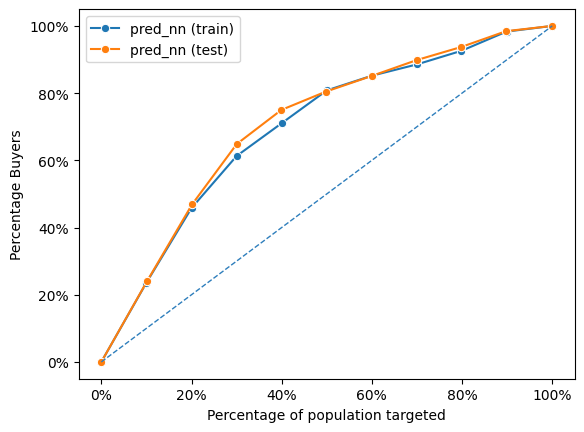

In [27]:
dct = {
    "train": titanic[titanic.training == 1],
    "test": titanic[titanic.training == 0],
}
fig = rsm.model.gains_plot(dct, rvar="survived", lev="Yes", pred="pred_nn")

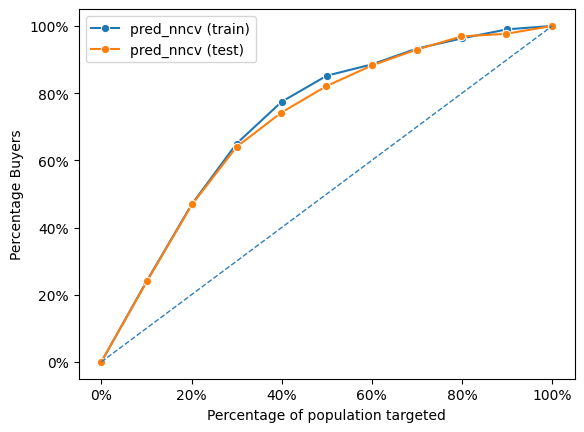

In [28]:
dct = {
    "train": titanic[titanic.training == 1],
    "test": titanic[titanic.training == 0],
}
fig = rsm.model.gains_plot(dct, rvar="survived", lev="Yes", pred="pred_nncv")

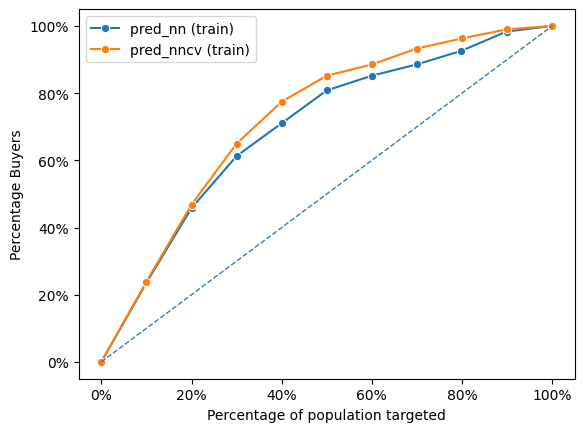

In [29]:
fig = rsm.model.gains_plot(
    {"train": titanic[titanic.training == 1]}, rvar="survived", lev="Yes", pred=["pred_nn", "pred_nncv"]
)

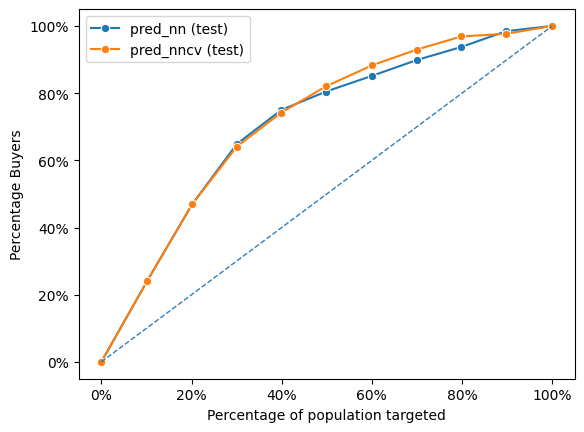

In [30]:
fig = rsm.model.gains_plot(
    {"test": titanic[titanic.training == 0]}, rvar="survived", lev="Yes", pred=["pred_nn", "pred_nncv"]
)